# Úkol č. 1 - předzpracování dat a binární klasifikace

  * **Deadline je do 31. října 23:59**, pokud odevzdáte úkol do 7. listopadu 23:59 budete penalizování -4 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **12 bodů**:
  * Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.
  * V notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na podmnožiny vhodné k trénování modelu.
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit. Pro průzkum dat využívejte vizualizace.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
  * Ukázka prvních řádků souboru *results.csv*:
  
```
ID,survived
1000,0
1001,1
...
```

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 16 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí křížové validace. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Vytvořte i csv soubor s predikcemi a uložte ho v rámci projektu (`results.csv`, vedle ipython notebooku).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [1]:
### odtud už je to Vaše
import pandas as pd
import numpy as np
from IPython.display import display

Nejdříve načteme data z `data.csv`.

In [2]:
data = pd.read_csv('data.csv')

Dále nahradíme otazníky s NaN z NumPy a podíváme se, jestli máme nějaké NaN

In [3]:
data = data.replace('?',np.nan)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        797 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      222 non-null    object 
 11  embarked   999 non-null    object 
 12  home.dest  573 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


Vytvoříme objekt DecisionTreeClassifier

In [4]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [5]:
data.dtypes

ID             int64
survived       int64
pclass         int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
home.dest     object
dtype: object

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# Upravení dat
Nejdříve upravíme data, abychom je mohli použít na učení.

Odebereme sloupce `'survived'`,` 'name'`,` 'home.dest'`, `'ticket'`.

In [7]:
columnsToDrop = {'name', 'home.dest','ID'}
data.drop(columns=columnsToDrop,inplace=True)

Dále musíme nahradit nevhodně zadané vstupy něčím co bude pro nás lepší. Tedy hodnoty v sloupečku `'sex'` nahradíme ze Stringu na bool a přejmenujeme sloupeček na `'isFemale'`.

In [8]:
mapping = {'male': 0, 'female': 1}
data.replace({'sex':mapping},inplace=True)
data.rename(columns={'sex':'isFemale'},inplace=True)

In [9]:
string_cols = data.select_dtypes(['object']).columns
data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes)

Také nahradíme všechny hodnoty `not a number` na -1

In [10]:
data.replace(np.nan, -1,inplace=True)

In [11]:
Xdata = data.drop(columns='survived')
ydata = data['survived']

A zkontrolujeme zdali jsou data v pořádku připravená

In [12]:
Xdata

,pclass,isFemale,age,sibsp,parch,ticket,fare,cabin,embarked
0,3,0,27.0,0,0,450,7.7958,-1,2
1,3,0,45.0,0,0,560,8.0500,-1,2
2,2,0,-1.0,0,0,153,0.0000,-1,2
3,3,1,27.0,0,2,388,11.1333,-1,2
4,1,0,28.0,1,0,662,82.1708,-1,0
...,...,...,...,...,...,...,...,...,...
995,1,1,22.0,0,0,43,151.5500,-1,2
996,2,0,21.0,0,0,687,73.5000,-1,2
997,1,1,24.0,0,0,640,69.3000,26,0
998,3,0,-1.0,8,2,626,69.5500,-1,2


## Rozdělení dat
Nyní rozdělíme data na trénovací část, testovací část. Trénovací část dále rozdělíme na data, která použijeme na trénování a na validační data

In [35]:
rd_seed = 420
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print("trénovací data před rozdělením")
display(Xtrain.shape)
display(ytrain.shape)
print("validační data")
display(Xtest.shape)
display(ytest.shape)

### xdata = nepouzivat
### xtrain = data na trenovani
### xval = data na prvni validaci
### xtest = data na testovani presnosti


Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
print('nové trénovací data')
display(Xtrain.shape)
display(ytrain.shape)
print('validační data')
display(Xval.shape)
display(yval.shape)

původní data


(1000, 9)

(1000,)

trénovací data před rozdělením


(750, 9)

(750,)

validační data


(250, 9)

(250,)

nové trénovací data


(562, 9)

(562,)

validační data


(188, 9)

(188,)

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

Dále zkusíme upravit více hyper parametrů pro dosažení větší přesnosti

In [29]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,34),
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)

In [31]:
val_acc = []
train_acc = []
test_acc = []
random_param = 420
for params in param_comb:
    dt = DecisionTreeClassifier(**params, random_state=random_param)
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))
    test_acc.append(metrics.accuracy_score(ytest,dt.predict(Xtest)))

best params  {'max_depth': 6, 'criterion': 'entropy'}
accuracy score (train): 0.875445
accuracy score (validation): 0.787234
accuracy score (test): 0.816000


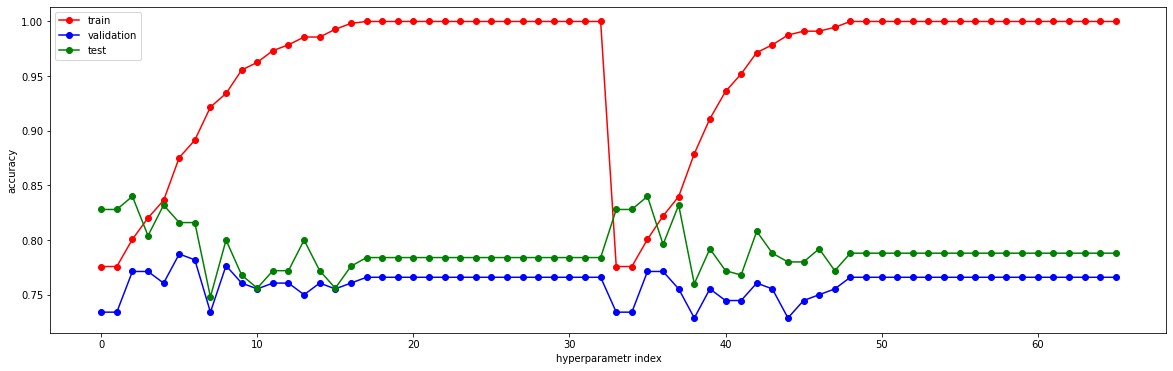

In [34]:

plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.plot(test_acc,'og-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation','test'])
best_params = param_comb[np.argmax(val_acc)]
print('best params ', best_params)
dt = DecisionTreeClassifier(**best_params, random_state=random_param)
dt.fit(Xtrain, ytrain)

In [42]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))
print('with parameters: {}'.format(best_params))

accuracy score (train): 0.875445
accuracy score (validation): 0.787234
accuracy score (test): 0.816000
with parameters: {'max_depth': 6, 'criterion': 'entropy'}


In [41]:
best_res = np.max(val_acc)
best_params = param_comb[np.argmax(val_acc)]

print("Best validation accuracy is {}% with parameters {}".format(best_res, best_params))

Best validation accuracy is 0.7872340425531915% with parameters {'max_depth': 6, 'criterion': 'entropy'}


In [19]:
best_params

{'max_depth': 16, 'criterion': 'gini'}

# Random forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Place your model training code here :)
param_grid = {
    'max_depth': range(1, 5),
    'n_estimators': range(1, 100, 10)
}

param_comb = ParameterGrid(param_grid)

val_metric_rf = []
for params in param_comb:
    dt = RandomForestClassifier(**params).fit(Xtrain, ytrain)
    val_metric_rf.append(metrics.accuracy_score(ydata, dt.predict(Xdata)))

In [21]:
best_res_rf = np.max(val_metric_rf)
best_params_rf = param_comb[np.argmax(val_metric_rf)]

print("Best validation accuracy is {}% with parameters {}".format(best_res_rf, best_params_rf))

Best validation accuracy is 0.83% with parameters {'n_estimators': 51, 'max_depth': 4}


# Předvídání zadaných vstupů

In [22]:
evaluate = pd.read_csv('evaluation.csv')
ids = evaluate['ID']
evaluate.drop(columns={ 'name', 'home.dest','ID'},inplace=True)
evaluate.replace({'sex':mapping},inplace=True)
evaluate.rename(columns={'sex':'isFemale'},inplace=True)
string_cols = evaluate.select_dtypes(['object']).columns
evaluate[string_cols] = evaluate[string_cols].astype('category').apply(lambda x: x.cat.codes)

In [23]:
evaluate.replace(np.nan,-1,inplace=True)

In [24]:
evaluate.drop(columns='embarked',inplace=True)

In [25]:
evaluate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    309 non-null    int64  
 1   isFemale  309 non-null    int64  
 2   age       309 non-null    float64
 3   sibsp     309 non-null    int64  
 4   parch     309 non-null    int64  
 5   ticket    309 non-null    int16  
 6   fare      309 non-null    float64
 7   cabin     309 non-null    int8   
dtypes: float64(2), int16(1), int64(4), int8(1)
memory usage: 15.5 KB


In [26]:
result = dt.predict(evaluate)

/home/dufko/vzd/.venv/lib/python3.8/site-packages/sklearn/base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- embarked

  warnings.warn(message, FutureWarning)


ValueError: X has 8 features, but RandomForestClassifier is expecting 9 features as input.

In [ ]:
resultJoin = pd.DataFrame({'ID':ids,'survived':result})

In [ ]:
resultJoin

,ID,survived
0,1000,1
1,1001,1
2,1002,1
3,1003,0
4,1004,0
...,...,...
304,1304,1
305,1305,0
306,1306,0
307,1307,0


In [ ]:
resultJoin.to_csv('result.cvs',index=None)

In [57]:
ytrain

66     1
12     1
500    0
43     0
724    1
      ..
747    1
948    0
614    0
381    0
552    0
Name: survived, Length: 562, dtype: int64

In [60]:
from sklearn.ensemble import AdaBoostClassifier
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.9, 0.75, 0.6, 0.8, 1],
    'n_estimators': range(1, 100, 10)
}

param_comb = ParameterGrid(param_grid)

val_ad = []
train_ad = []
for params in param_comb:
    ad = AdaBoostClassifier(**params)
    ad.fit(Xtrain.values, ytrain.values)
    val_ad.append(metrics.accuracy_score(yval, ad.predict(Xval.values)))
    train_ad.append(metrics.accuracy_score(ytrain, ad.predict(Xtrain.values)))

In [50]:
Xtrain

,pclass,isFemale,age,sibsp,parch,ticket,fare,cabin,embarked
66,2,1,50.0000,0,0,631,10.5000,-1,2
12,2,0,0.8333,1,1,268,18.7500,-1,2
500,3,0,-1.0000,0,0,530,7.7500,-1,1
43,3,0,70.5000,0,0,519,7.7500,-1,1
724,3,1,22.0000,1,0,365,13.9000,-1,2
...,...,...,...,...,...,...,...,...,...
747,3,0,-1.0000,0,0,230,7.2292,-1,0
948,3,0,33.0000,0,0,424,8.6625,-1,0
614,3,1,36.0000,0,2,460,12.1833,-1,2
381,2,0,19.0000,1,1,614,36.7500,-1,2
